In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"simulate_ball_bounce")); 

# Pkg.add("ForwardDiff")
# Pkg.add("Plots")
# Pkg.add("PlotlyJS")
# Pkg.add("DifferentialEquations")
# Pkg.add("Distributions")
# Pkg.add("Arpack")
# Pkg.add("SparseArrays")
# Pkg.resolve()
Pkg.update()
Pkg.instantiate()

using ForwardDiff 
using LinearAlgebra
using Statistics
using Plots
plotlyjs()
using Printf
using Random
using DifferentialEquations
using Distributions
using Arpack
using SparseArrays

const FD = ForwardDiff;

PLOTS_DEFAULTS = Dict(:dpi => 600);

include("GeneralizedFunctionality/est_parameters.jl");
include("GeneralizedFunctionality/hybrid_system_simulation_tools.jl")
include("GeneralizedFunctionality/SKF_general.jl")
include("GeneralizedFunctionality/batch_estimation.jl")
include("GeneralizedFunctionality/generalized_saltation_calculations.jl")
include("DynamicSystems/4link_biped.jl") # Defines hybrid system functions

  Activating environment at `c:\Users\14088\Documents\GitHub\OCRL-Walker-Project\juliaImplementation\juliaImplementation\src\simulate_ball_bounce\Project.toml`
    Updating registry at `C:\Users\14088\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Installed Missings ─────────────── v1.2.0
   Installed RecursiveFactorization ─ v0.2.22
   Installed OffsetArrays ─────────── v1.14.0
   Installed Polyester ────────────── v0.7.12
   Installed StrideArraysCore ─────── v0.5.5
   Installed Functors ─────────────── v0.4.10
   Installed FillArrays ───────────── v1.10.0
   Installed Plots ────────────────── v1.40.4
   Installed ArrayLayouts ─────────── v1.9.2
   Installed EnzymeCore ───────────── v0.6.6
   Installed Formatting ───────────── v0.4.3
   Installed DataStructures ───────── v0.18.19
   Installed ColorTypes ───────────── v0.11.5
   Installed LoopVectorization ────── v0.12.169
   Installed Optim ────────────────── v1.9.4
   Installed M

set_params (generic function with 1 method)

# Nominal trajectory for four-link biped walker

The system dynamics, resets, and guards for the biped walker are defined here. 
`dynamics` holds the functions for the walker's behavior, `resets` defines the state-resetting functions upon hitting the ground, and `guards` determines the conditions for transitions between different modes of motion.

The nominal trajectory is plotted.

In [2]:
# system definition
dynamics = [unlocked_dynamics, locked_dynamics]
resets = [[idreset, kneestrike_reset],[heelstrike_reset, idreset]]
guards = [[idguard, kneestrike_guard],[heelstrike_guard, idguard]]

# initial states
mode0 = 1
# xmean = [pi/9, pi/6, pi/3, 0, 0, 0]

q1 = 0.1877
q2 = -0.2884
q3 = q2
q̇1 = -1.1014
q̇2 = 0.0399
q̇3 = q̇2

xmean = [q1, q2, q3, q̇1, q̇2, q̇3]

# simulation times
t = 0.7 #10
dt = .01 #.1

# noise and measurement parameters - we probably won't need this
W = Diagonal([1.0,1.0,1.0,1.0,1.0,1.0])*0.1
V = Diagonal([1.0,1.0])*.001
C = [I zeros(2,4)]

# structure of all this
param = ESTParameters(C,V,W,dt,dynamics,resets,guards)

# simulate nominal trajectory
nom_states, _, _, nom_modes,nom_impact_states,_ = sim_system(xmean,mode0,dynamics,resets,guards,W*.000000000000001,V,C,t,dt);
state_matrix = hcat(nom_states...);
display(size(state_matrix))

OMG MODE SWITCHHHH
1
2
[-0.10689488803839592, 0.330705950738765, 0.33070595073876474, -0.9381288966834588, -0.1785824354509692, 8.734677038690407]
0.4124768935499607
OMG MODE SWITCHHHH
2
1
[-0.17924157929365755, 0.07844157929365793, 0.07844157929365765, -0.7105996976187221, -2.8005349841287, -2.8005349841287]
0.6198657224272132


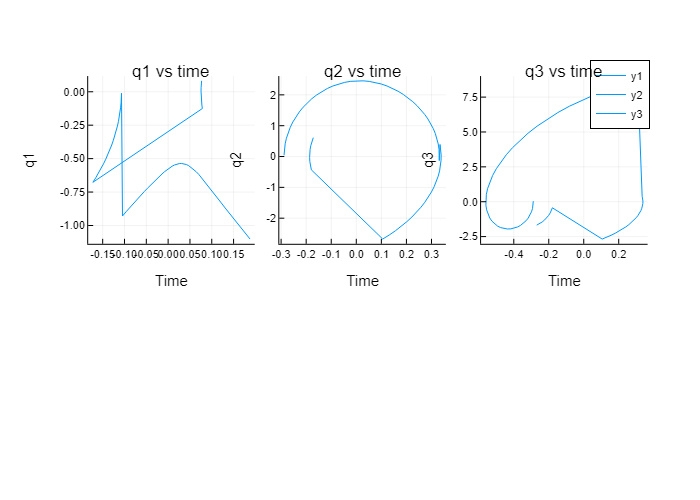

In [3]:
# plot each angle over time
timesteps = 0:dt:t 
p = plot(layout = (2, 3), size = (1000, 500))
    

state_names = ["q1", "q2", "q3", "dq1", "dq2", "dq3"]

# for i in 1:6
#     plot!(p[i], timesteps, [state[i] for state in nom_states],
#           title = "$(state_names[i]) vs time",
#           xlabel = "Time",
#           ylabel = "$(state_names[i])",
#           legend = false,
#           titlefontsize = 12)
# end

for i in 1:3
    plot!(p[i], [state[i] for state in nom_states],[state[i+3] for state in nom_states],
          title = "$(state_names[i]) vs time",
          xlabel = "Time",
          ylabel = "$(state_names[i])",
          legend = false,
          titlefontsize = 12)
end

display(p)

In [4]:
# Initialize an Animation object
anim = Animation()
lim = 1.5
# Loop to create frames
for i in 1:100
    js = hcat(q2joints(state_matrix[:,i])...)
    # Plot the data
    plot(js[1,:], js[2,:], xlim=(-lim,lim), ylim=(-lim,lim), label="Points", color="blue", linestyle=:solid, marker=:circle)
    # Plot the ground
    x = -10:0.1:10
    m = set_params()
    m = -tan(m[:gamma])
    y = m*x

    plot!(x, y, color="black", label="ground")
    # Add frame to animation
    frame(anim)
end
# Save the animation as a gif
gif(anim, "walker.gif", fps = 15)

BoundsError: BoundsError: attempt to access 6×71 Matrix{Float64} at index [1:6, 72]

In [5]:
first_heelstrike = [-0.17907967769858749, 0.07907967769858765, 0.07907967769858743, -0.7098263826878617, -2.7977515963609325, -2.7977515963609325]
first_heel_pos = q2joints(first_heelstrike[1:3])

4-element Vector{Vector{Float64}}:
 [0.0, 0.0]
 [0.17812404444366126, 0.9840080410194992]
 [0.21762268515100247, 0.48557062530688205]
 [0.2571213258583436, -0.012866790405735129]